In [81]:
import pickle
import os

FOLDER = os.getcwd() + "/4_pts_blurry"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time
from util import *
from SyMBac.PSF import PSF_generator

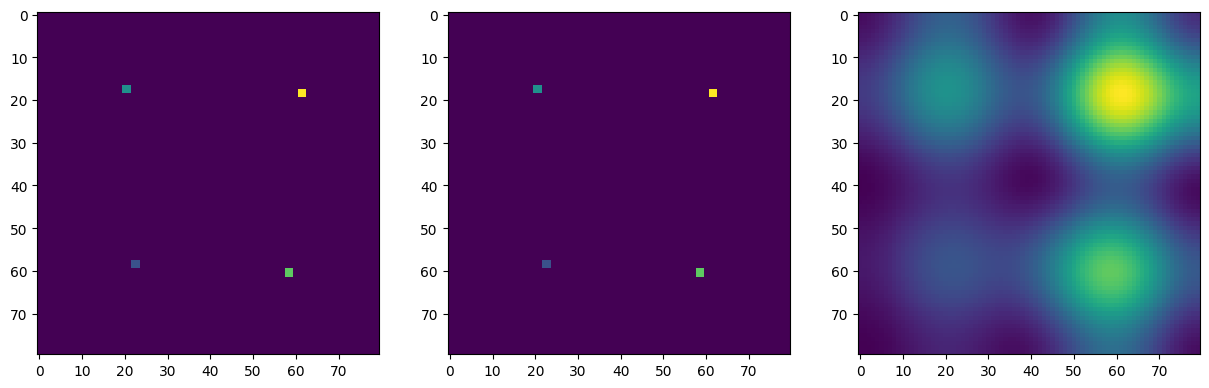

In [83]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

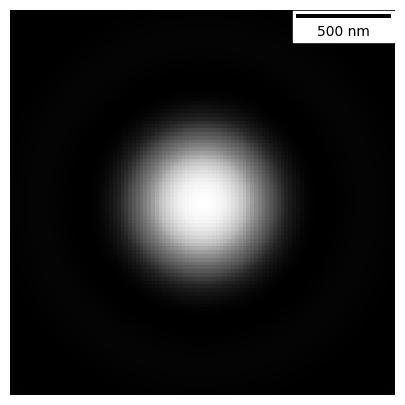

[[0.00414948 0.00415171 0.00409537 ... 0.00409537 0.00415171 0.00414948]
 [0.00415171 0.00409358 0.00397612 ... 0.00397612 0.00409358 0.00415171]
 [0.00409537 0.00397612 0.00379854 ... 0.00379854 0.00397612 0.00409537]
 ...
 [0.00409537 0.00397612 0.00379854 ... 0.00379854 0.00397612 0.00409537]
 [0.00415171 0.00409358 0.00397612 ... 0.00397612 0.00409358 0.00415171]
 [0.00414948 0.00415171 0.00409537 ... 0.00409537 0.00415171 0.00414948]]


/home/boomalope/symbac/symbac/lib/python3.8/site-packages/SyMBac/PSF.py:178: RuntimeWarning: invalid value encountered in divide
  PSF = (2 * jv(1, rr) / (rr)) ** 2


In [84]:
my_kernel = PSF_generator(
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.0, 
    n = 1.4, 
    resize_amount = 1, 
    pix_mic_conv = 0.02, 
    apo_sigma = 8, 
    mode="simple fluo", 
    condenser = "Ph3",
    offset = 0
)
my_kernel.calculate_PSF()
my_kernel.plot_PSF()
psf = my_kernel.get_fluorescence_kernel(my_kernel.wavelength,my_kernel.NA,my_kernel.n,my_kernel.radius,my_kernel.scale)
print(psf)

In [85]:
#Get all sourcePts

sourcePts = []

(maskWidth, maskHeight) = mask.shape

for i in range(maskWidth):
    for j in range(maskHeight):
        if mask[i,j] != 0:
            sourcePts.append([i,j])
print(len(sourcePts))

#Take only a random subset of the sourcePts

random.shuffle(sourcePts)
sourcePts = sourcePts[:]

print(sourcePts)

#Assemble the matrix
additionalPts = []
for _ in range(0):
    x = random.randint(0,len(out)-1)
    y = random.randint(0,len(out[0])-1)
    additionalPts.append([x,y])

#Include points along the edge
for i in range(len(out)):
    additionalPts.append([i,0])
    additionalPts.append([i,len(out[0])-1])
for i in range(len(out[0])):
    additionalPts.append([0,i])
    additionalPts.append([len(out)-1,i])

print(len(additionalPts))

#Count number of unique masked points
maskedPts = []
b_ori = []
for i in range(len(mask)):
    for j in range(len(mask[0])):
        if mask[i,j] not in maskedPts and mask[i,j] != 0:
            maskedPts.append(mask[i,j])
            b_ori.append(ori[i,j])

print(maskedPts)
print(b_ori)

16
[[61, 59], [17, 21], [18, 61], [60, 58], [19, 62], [58, 23], [58, 22], [18, 20], [18, 62], [59, 23], [18, 21], [61, 58], [60, 59], [17, 20], [19, 61], [59, 22]]
320
[0.5, 1.0, 0.25, 0.75]
[0.5, 1.0, 0.25, 0.75]


In [86]:
b = []
for (x,y) in sourcePts:
    b.append(AverageFilter(out,x,y))
for (x,y) in additionalPts:
    b.append(AverageFilter(out,x,y))
b = np.array(b)
b = b/(2**16-1)

A = []

for x in sourcePts:
    a = [0 for _ in range(len(maskedPts))]
    for y in sourcePts:
        a[maskedPts.index(mask[y[0]][y[1]])] += GetPSFMatrix(y,x,psf)
    A.append(a)
for x in additionalPts:
    a = [0 for _ in range(len(maskedPts))]
    for y in sourcePts:
        a[maskedPts.index(mask[y[0]][y[1]])] += GetPSFMatrix(y,x,psf)
    A.append(a)
A = np.array(A)

#Solve the matrix
x_bar = np.linalg.lstsq(A, b)
print(x_bar)


(array([0.13392322, 0.27127314, 0.06483797, 0.19874028]), array([0.20065717]), 4, array([10.42526702,  9.78732178,  9.43271555,  8.5957328 ]))


/tmp/ipykernel_18006/2758953623.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_bar = np.linalg.lstsq(A, b)


[[1.         0.99978315]
 [0.99978315 1.        ]]


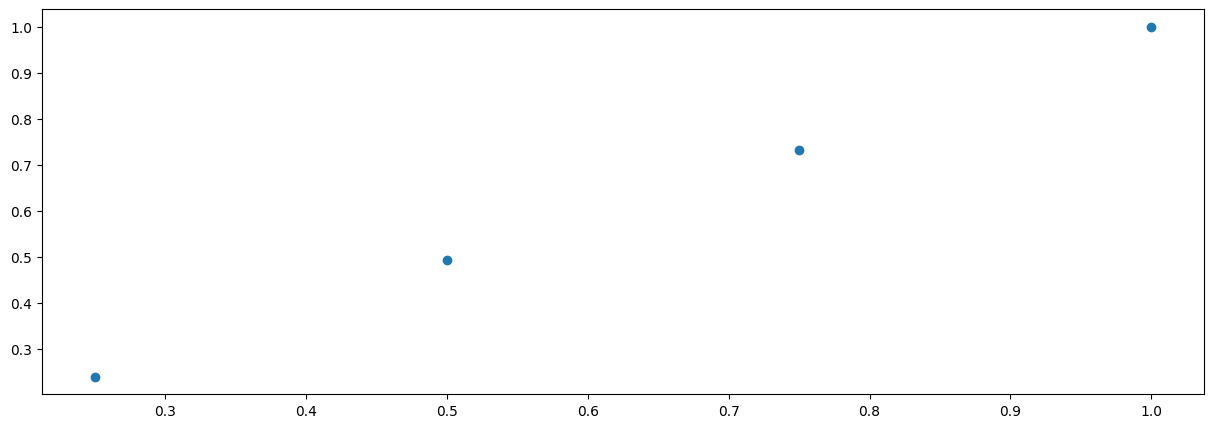

In [87]:
#Plot the result
plt.scatter(b_ori, x_bar[0]/max(x_bar[0]))
#Get correlation coefficient
print(np.corrcoef(b_ori, x_bar[0]/max(x_bar[0])))

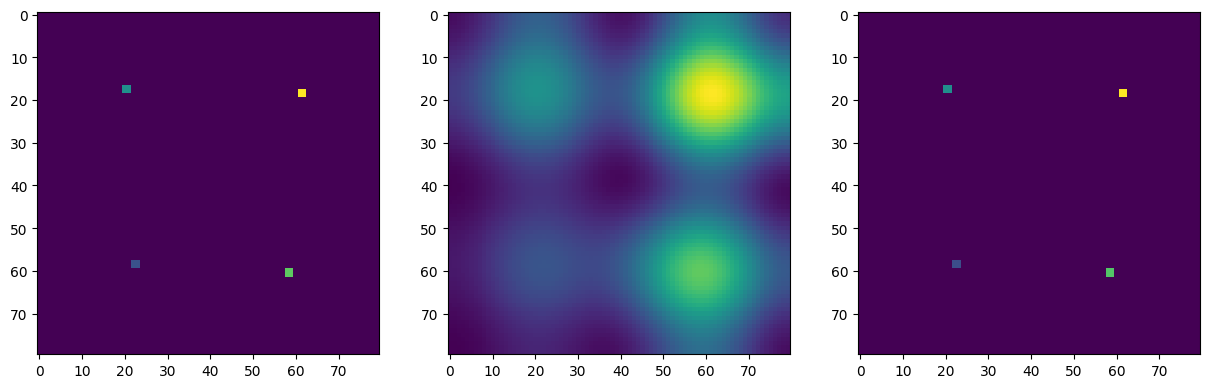

In [88]:
recoveredImage = np.zeros((len(mask),len(mask[0])))

for i in range(len(mask)):
    for j in range(len(mask[0])):
        if mask[i,j] != 0:
            recoveredImage[i,j] = x_bar[0][maskedPts.index(mask[i,j])]
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(out)
axarr[2].imshow(recoveredImage)
plt.show()